In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

In [2]:
DATA_PATH = '/Users/mpekey/Desktop/FlyVideo/Peak_Signal_Data'

experiment_features = ['pose.prob_x', 'pose.prob_y', 'distance.head-prob', 'distance.origin-prob']

### Read Data

In [3]:
filename = os.path.join(DATA_PATH, 'bouts_dict.pkl')
with open(filename, 'rb') as f:
    bouts_dict = pickle.load(f)

true_peak_fn = os.path.join(DATA_PATH, 'true_peak_annotations.npy')
true_peak_df_fn = os.path.join(DATA_PATH, 'true_annotations_new.pkl')

true_peak_annotations_array = np.load(true_peak_fn)
with open(true_peak_df_fn, 'rb') as f:
    true_peak_annotations_df = pickle.load(f)

### Utils

In [6]:
def create_input_data(fly, experiment, features):
    
    input_data = bouts_dict[fly][features[0]][experiment].reshape(-1,1)

    for i in range(1, len(features)):
        input_data = np.concatenate((input_data,
                                    bouts_dict[fly][features[i]][experiment].reshape(-1,1)),
                                    axis=1)
    return input_data

class FlyInfo:
    def __init__(self, name, trial_id, peak_index, peak_values):
        self.name = name
        self.trial_id = trial_id
        self.peak_index = peak_index
        self.peak_values = peak_values

class FlyDatabase:
    def __init__(self):
        self.fly_data = []

    def add_fly(self, fly_info):
        self.fly_data.append(fly_info)

    def get_fly(self, name, trial_id):
        for fly_info in self.fly_data:
            if fly_info.name == name and fly_info.trial_id == trial_id:
                return fly_info
        return None
    
    def write_fly_info(self, name, trial_id):
        for fly_info in self.fly_data:
            if fly_info.name == name and fly_info.trial_id == trial_id:
                print('Name:', fly_info.name)
                print('Trial Id:', fly_info.trial_id)
                print('Peak Index:', fly_info.peak_index)
                print('Peak Values:', fly_info.peak_values)
                return None
        print('Fly not found!!!')
        return None

### Fly Database

In [7]:
fly_db = FlyDatabase()

fly_names = true_peak_annotations_df['name'].unique()

for name in fly_names:
    trial_idxs = true_peak_annotations_df[true_peak_annotations_df['name'] == name]['trial_id'].unique().tolist()
    for idx in trial_idxs:
        peak_index = true_peak_annotations_df[(true_peak_annotations_df['name'] == name) & (true_peak_annotations_df['trial_id'] == idx)]['peak_index'].values
        peak_values = true_peak_annotations_df[(true_peak_annotations_df['name'] == name) & (true_peak_annotations_df['trial_id'] == idx)]['value'].values
        fly_db.add_fly(FlyInfo(name, idx, peak_index, peak_values))

### Calculating Feature Means

In [8]:
import random

validation_ratio = 0.2
all_flies = fly_db.fly_data
num_validation_samples = int(len(all_flies) * validation_ratio)
random.shuffle(all_flies)

train_data = all_flies[num_validation_samples:]
val_data = all_flies[:num_validation_samples]

In [9]:
print('Train Data:', len(train_data), 'Validation Data:', len(val_data))

Train Data: 1175 Validation Data: 293


In [10]:
from scipy import stats
def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]

def normalize(arr):
    #return (arr - arr.min()) / (arr.max() - arr.min())
    return stats.zscore(arr)

train_feat_means = {}

for feat in experiment_features:
    train_feat_means[feat] = np.mean(flatten_list([normalize(np.array(bouts_dict[fly.name][feat][int(fly.trial_id)])) for fly in train_data]))

In [11]:
train_feat_means

{'pose.prob_x': -2.0253326726230264e-19,
 'pose.prob_y': 1.4158425603416701e-16,
 'distance.head-prob': 6.287307726712748e-17,
 'distance.origin-prob': 2.299832760852534e-16}

In [12]:
train_concat_feat = {}

for feat in experiment_features:
    all_feats = []
    for i, fly in enumerate(train_data):
        all_feats.extend(normalize(np.array(bouts_dict[fly.name][feat][int(fly.trial_id)])).tolist())
        if i != len(train_data) - 1:
            all_feats.extend([train_feat_means[feat]])
    train_concat_feat[feat] = np.array(all_feats)

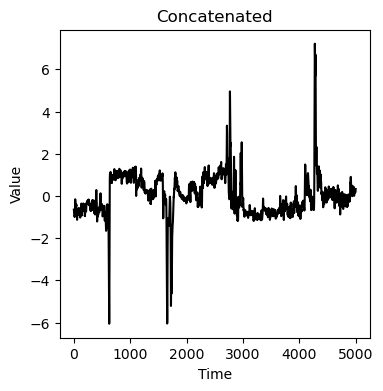

In [14]:
plt.figure(figsize=(4,4))
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(train_concat_feat['distance.origin-prob'][:5000], color='black')
plt.title("Concatenated")
plt.show()

### Creating Train & Test Data

In [15]:
input_train_data = train_concat_feat[experiment_features[0]].reshape(-1, 1)

for i in range(1, len(experiment_features)):
    input_train_data = np.concatenate((input_train_data,
                                       train_concat_feat[experiment_features[i]].reshape(-1, 1)),
                                       axis=1)

print(input_train_data.shape)


(2106140, 4)


In [27]:
input_val_data = []
input_val_labels = [val_fly.peak_index for val_fly in val_data]
for fly in val_data:
    input_val_data.append(
        np.concatenate((
            normalize(np.array(bouts_dict[fly.name][experiment_features[0]][int(fly.trial_id)])).reshape(-1,1),
            normalize(np.array(bouts_dict[fly.name][experiment_features[1]][int(fly.trial_id)])).reshape(-1,1),
            normalize(np.array(bouts_dict[fly.name][experiment_features[2]][int(fly.trial_id)])).reshape(-1,1),
            normalize(np.array(bouts_dict[fly.name][experiment_features[3]][int(fly.trial_id)])).reshape(-1,1)
        ),
        axis = 1))

### Fitting Model

In [61]:
model = IsolationForest(n_estimators = 100,
                        contamination=0.06,
                        max_samples='auto',
                        max_features=1.0,
                        bootstrap=False)

model.fit(input_train_data)

IsolationForest(contamination=0.06)

### Evaluating Model

In [62]:
def filter_prediction(anomalies, grouped_range=60):
    idx_group = []
    all_groups = []
    for idx in list(anomalies.index):
        if idx in idx_group:
            continue
        idx_group = []
        for i in range(idx, idx+grouped_range):
            if i in list(anomalies.index):
                idx_group.append(i)
        all_groups.append(idx_group)
    
    group_pred_idx = []
    group_pred_val = []
    for group in all_groups:
        group_vals = anomalies.loc[group]['distance.origin-prob']
        if len(group_vals) > 1 and group_vals.iloc[0] < group_vals.iloc[1]:
            pred = group_vals[group_vals == group_vals.max()]
        else:
            pred = group_vals[group_vals == group_vals.min()]
        group_pred_idx.append(pred.index.values[0])
        group_pred_val.append(pred.values[0])
    return group_pred_idx, group_pred_val

In [63]:
def calculate_grouped_recall(predicted_peaks, true_peaks, matching_range):
    recall_predictions = []
    for true_idx in true_peaks:
        found_true_pred = False
        for pred_idx in predicted_peaks:
            if abs(pred_idx - true_idx) <= matching_range:
                found_true_pred = True
                break
        recall_predictions.append(found_true_pred)
    recall = np.sum(recall_predictions) / len(recall_predictions)
    return recall

def calculate_grouped_precision(predicted_peaks, true_peaks, matching_range):
    precision_predictions = []
    for pred_idx in predicted_peaks:
        found_pred = False
        for true_idx in true_peaks:
            if abs(pred_idx - true_idx) <= matching_range:
                found_pred = True
                break
        precision_predictions.append(found_pred)
    
    if len(precision_predictions) > 0:
        precision = np.sum(precision_predictions) / len(precision_predictions)
        return precision
    else:
        return 0.0

def calculate_f1_score(precision, recall):
    if precision + recall > 0.0:
        return (2 * precision * recall) / (precision + recall)
    else:
        return 0.0


def evaluate_results(all_results, matching_range = 30):
    avg_recall, avg_precision, avg_f1_score = 0, 0, 0
    all_recall, all_precision, all_f1_score, all_true_pred_ratio = [], [], [], []

    for res in all_results:
        predicted_peaks = res['predicted_index']
        true_peaks = res['true_index']
        
        recall = calculate_grouped_recall(predicted_peaks, true_peaks, matching_range)
        precision = calculate_grouped_precision(predicted_peaks, true_peaks, matching_range)
        f1_score = calculate_f1_score(precision, recall)

        all_recall.append(recall)
        all_precision.append(precision)
        all_f1_score.append(f1_score)
        all_true_pred_ratio.append(len(predicted_peaks) / len(true_peaks))

        avg_recall += recall
        avg_precision += precision
        avg_f1_score += f1_score

    avg_recall /= len(all_results)
    avg_precision /= len(all_results)
    avg_f1_score /= len(all_results)
    
    return {
        'avg_metrics' : {
            'avg_recall' : avg_recall,
            'avg_precision' : avg_precision,
            'avg_f1_score' : avg_f1_score
            },
        'all_metrics' : {
            'all_recall' : all_recall,
            'all_precision' : all_precision,
            'all_f1_score' : all_f1_score
            },
        'true_pred_amount' : {
            'true_amounts' : [len(res['true_index']) for res in all_results],
            'pred_amounts' : [len(res['predicted_index']) for res in all_results]
            }
        }

In [58]:
def evaluate_model(input_data, input_labels, grouped_range):
    all_results, all_results_group = [], []

    for fly_idx in range(len(input_data)):
        eval_df = pd.DataFrame(input_data[fly_idx], columns = experiment_features)
        eval_df['predictions'] = model.predict(input_data[fly_idx])
        
        anomalies = eval_df.loc[eval_df['predictions'] == -1, ['distance.origin-prob']]
        anomalies_idx = list(anomalies.index)

        group_pred_idx, group_pred_val = filter_prediction(anomalies, grouped_range=grouped_range)
        
        all_results.append({'true_index': input_labels[fly_idx], 'predicted_index': anomalies_idx})
        all_results_group.append({'true_index': input_labels[fly_idx], 'predicted_index': group_pred_idx})

    results = evaluate_results(all_results)
    results_g = evaluate_results(all_results_group)

    return results, results_g

In [68]:
results, results_g = evaluate_model(input_val_data, input_val_labels, grouped_range=60)

In [69]:
print(results['avg_metrics'])
print('##################')
print(results_g['avg_metrics'])

{'avg_recall': 0.9007859133323579, 'avg_precision': 0.825262981156024, 'avg_f1_score': 0.8362909669198896}
##################
{'avg_recall': 0.8924932326397247, 'avg_precision': 0.8294528130065514, 'avg_f1_score': 0.836737576027596}


In [70]:
output_dirs = ['0_20', '20_40', '40_60']
base_dir = 'concat_peak_outputs'

if not os.path.exists(base_dir):
    os.makedirs(base_dir)

for dir_name in output_dirs:
    dir_path = os.path.join(base_dir, dir_name)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

for i, f_score in enumerate(results_g['all_metrics']['all_f1_score']):
    if f_score >= 0.4 and f_score < 0.6:
        rec_range = '40_60'
    elif f_score >= 0.2 and f_score < 0.4:
        rec_range = '20_40'
    elif f_score >= 0.0 and f_score < 0.2:
        rec_range = '0_20'
    else:
        continue

    all_results_group = []
    test_input = input_val_data[i]
    test_label = input_val_labels[i]

    eval_df = pd.DataFrame(test_input, columns = experiment_features)
    eval_df['predictions'] = model.predict(test_input)
    
    anomalies = eval_df.loc[eval_df['predictions'] == -1, ['distance.origin-prob']]
    anomalies_idx = list(anomalies.index)

    group_pred_idx, group_pred_val = filter_prediction(anomalies, grouped_range=60)
    all_results_group.append({'true_index': test_label, 'predicted_index': group_pred_idx})

    plt.plot(eval_df.index, eval_df['distance.origin-prob'], color='black', label = 'Normal')
    plt.scatter(group_pred_idx, group_pred_val, color='red', label = 'Anomaly')
    for true_peaks in test_label:
        min_range, max_range = true_peaks - 30, true_peaks + 30
        plt.axvspan(min_range, max_range, color='yellow', alpha=0.3)
    plt.title("Predicted Peaks")
    plt.legend(fontsize='small')
    plot_filename_all = os.path.join(os.path.join(base_dir, rec_range), f"{val_data[i].name}_{val_data[i].trial_id}.png")
    plt.savefig(plot_filename_all)
    plt.close()


In [84]:
test_old_data = {}

for i in val_data:
    test_old_data[f'{i.name}?{i.trial_id}'] = i.trial_id

print(len(test_old_data))
import pickle

with open("test_old_data.pkl", "wb") as file:
    pickle.dump(test_old_data, file)

293


In [76]:
len(test_old_data)

55

### Example Predictions

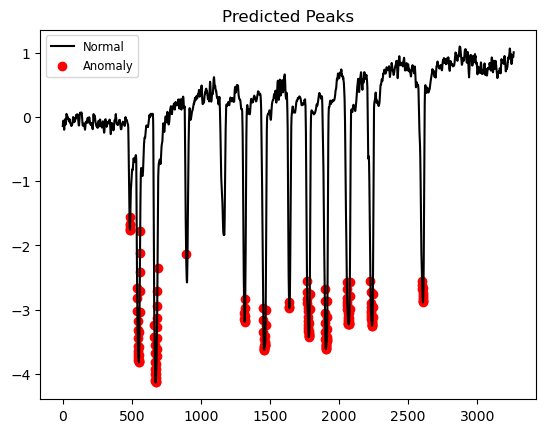

In [28]:
val_input = input_val_data[17]

eval_df = pd.DataFrame(val_input, columns = experiment_features)
eval_df['predictions'] = model.predict(val_input)

anomalies = eval_df.loc[eval_df['predictions'] == -1, ['distance.origin-prob']]
plt.plot(eval_df.index, eval_df['distance.origin-prob'], color='black', label = 'Normal')
plt.scatter(anomalies.index, anomalies['distance.origin-prob'], color='red', label = 'Anomaly')
plt.title("Predicted Peaks")
plt.legend(fontsize='small')
plt.show()

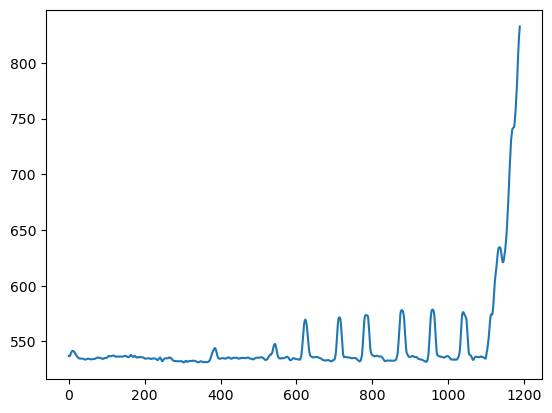

In [75]:
error_fly = val_data[6]

plt.plot(np.array(bouts_dict[error_fly.name]['distance.origin-prob'][int(error_fly.trial_id)]))
plt.show()

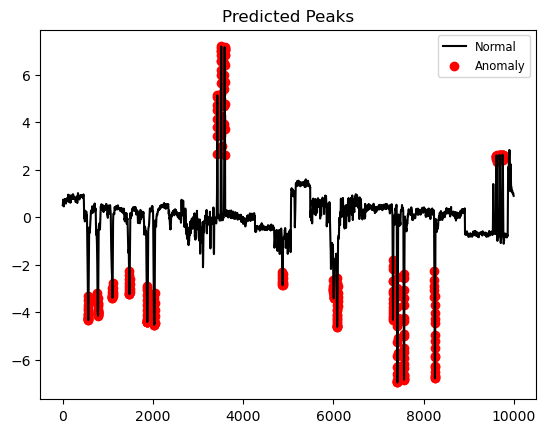

In [90]:
eval_df = pd.DataFrame(input_train_data[:10000], columns = experiment_features)
eval_df['predictions'] = model.predict(input_train_data[:10000])

anomalies = eval_df.loc[eval_df['predictions'] == -1, ['distance.origin-prob']]
plt.plot(eval_df.index, eval_df['distance.origin-prob'], color='black', label = 'Normal')
plt.scatter(anomalies.index, anomalies['distance.origin-prob'], color='red', label = 'Anomaly')
plt.title("Predicted Peaks")
plt.legend(fontsize='small')
plt.show()